## Business Understanding

As a data analyst/scientist I am interested in knowing what the job market looks like for myself and my peers. 
By analyzing what employers are looking for and also what they are offering my objective is to better equip myself and colleagues with actionable information as to which factors influence salary as well as other useful insights that can be used when searching and applying for data analyst and scientist positions.

## Data Understanding

Source:
This dataset was created by picklesueat on Kaggle and contains 2253 job listing for data analyst positions scraped from the Glassdoor.com

Features of interest:
* Job Title
* Salary Estimate (range of USD per annum)
* Company Rating on Glassdoor
* Company Name
* Location
* Size
* Company Type
* Sector/Industry
* Job Description


In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVC

In [2]:
# Read in the csv data
df = pd.read_csv("DataAnalyst.csv")
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


## Data Preparation

Just looking at the above data there are a number of issues with the data that need to be cleaned up.

* An index column already exists that can be safely dropped.
* Salary estimates are put into buckets. This isn't a cleaning issue but doesn't give us the granularity over salary expectation that I was hoping for.
* Company name seems to have a line break and the company's rating appended to the end of the name's text.
* Missing values seem to be encoded as -1 and need to be converted to numpy NaN's.
* The Easy Apply column can most likely be dropped as this does not add much value to our exploration.

In [3]:
# Drop old index, 'Easy Apply' and 'Competitors' column.
df = df.drop(['Unnamed: 0', 'Easy Apply', 'Competitors'],axis=1)

## Dealing with missing values

In [4]:
# Rename all null sectors and industries (encoded as -1) to 'Unspecified' 
df.loc[df['Sector'] == '-1', ['Sector']] = 'Unspecified'
df.loc[df['Industry'] == '-1', ['Industry']] = 'Unspecified'

# In the case of 'Type of ownership' and 'Size' "Unknown" already exists as a category in addition to -1 for null so we will use that.
df.loc[df['Type of ownership'] == '-1', ['Type of ownership']] = 'Unknown'
df.loc[df['Size'] == '-1', ['Size']] = 'Unknown'

df.loc[df['Revenue'] == '-1', ['Revenue']] = 'Unknown / Non-Applicable'


In [5]:
# Impute mode for missing values in year 'Founded'
imputer = SimpleImputer(missing_values = -1, strategy ='most_frequent')  
imputer = imputer.fit(df[['Founded']])
  
# Imputing the data      
df['Founded']=imputer.fit_transform(df[['Founded']]).ravel()

In [6]:
df['Company Age'] = 2020 - df['Founded'] 

In [7]:
# Impute mean for missing values in 'Rating' column
imputer = SimpleImputer(missing_values = -1, strategy ='mean')  
imputer = imputer.fit(df[['Rating']])
  
# Imputing the data      
df['Rating']=imputer.fit_transform(df[['Rating']]).ravel()

In [8]:
# Splitting state code from location into new column
df['State'] = df['Location'].str[-2:]

To clean up the company names we need to remove the rating at the end of each name.
To save time I just removed the last four characters of each name '\nx.x' but this would be a problem for company names that did not have a rating so I had to exclude them from the process first.

In [9]:
df.loc[df['Rating'] != -1,['Company Name']] = df.loc[df['Rating'] != -1]['Company Name'].str[:-4]

Above we can see the Company Name column no longer has the rating appended to each name.

In [10]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Company Age,State
0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),59,NY
1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),127,NY
2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,17,NY
3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),18,NY
4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),11,NY


In [11]:
pd.unique(df['Salary Estimate'])

array(['$37K-$66K (Glassdoor est.)', '$46K-$87K (Glassdoor est.)',
       '$51K-$88K (Glassdoor est.)', '$51K-$87K (Glassdoor est.)',
       '$59K-$85K (Glassdoor est.)', '$43K-$76K (Glassdoor est.)',
       '$60K-$110K (Glassdoor est.)', '$41K-$78K (Glassdoor est.)',
       '$45K-$88K (Glassdoor est.)', '$73K-$127K (Glassdoor est.)',
       '$84K-$90K (Glassdoor est.)', '$27K-$52K (Glassdoor est.)',
       '$42K-$74K (Glassdoor est.)', '$77K-$132K (Glassdoor est.)',
       '$98K-$114K (Glassdoor est.)', '$48K-$96K (Glassdoor est.)',
       '$26K-$47K (Glassdoor est.)', '$31K-$59K (Glassdoor est.)',
       '$47K-$81K (Glassdoor est.)', '$43K-$69K (Glassdoor est.)',
       '$49K-$112K (Glassdoor est.)', '$30K-$54K (Glassdoor est.)',
       '$55K-$103K (Glassdoor est.)', '$37K-$70K (Glassdoor est.)',
       '$57K-$103K (Glassdoor est.)', '$35K-$45K (Glassdoor est.)',
       '$42K-$66K (Glassdoor est.)', '$65K-$81K (Glassdoor est.)',
       '$113K-$132K (Glassdoor est.)', '$42K-$63K (Glas

Looking at the salary estimate column's distinct values we can spot a problem. There is a high amount of overlap between salary ranges. 

We could take the median of each range as the response and then perhaps calculate on average how large each salary range is and apply that at the end of the prediction. 

But first lets split our response into an upper and lower estimate and take it from there.

In [12]:
# CLEANING OF ESTIMATED SALARY #

# Drop the salary estimates that are null (encoded as -1 in this case)
df = df.drop(df.loc[df['Salary Estimate'] == '-1'].index, axis=0)

#Split the upper and lower salary estimate into two columns.
df['Lower Estimate'] = df['Salary Estimate'].str.split(pat="-", n=1, expand=True)[0]
df['Upper Estimate'] = df['Salary Estimate'].str.split(pat="-", n=1, expand=True)[1]

#Strip out everything except the number itself.
df['Lower Estimate'] = df['Lower Estimate'].str.strip('$K(Glassdoorest.)')
df['Upper Estimate'] = df['Upper Estimate'].str.strip('$K(Glassdoor est.)')

#Convert to integer and multiply by 1000 to get salary estimate in USD.
df['Lower Estimate'] = pd.to_numeric(df['Lower Estimate']) * 1000
df['Upper Estimate'] = pd.to_numeric(df['Upper Estimate']) * 1000

# Create a median estimate column assuming that most negotations could end up somewhere near the middle of the range.
df['Median Estimate'] = (df['Upper Estimate'] - df['Lower Estimate'] / 2)

# Drop original salary estimate column.
df = df.drop('Salary Estimate', axis=1)


df.head()

,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Company Age,State,Lower Estimate,Upper Estimate,Median Estimate
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),59,NY,37000,66000,47500.0
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),127,NY,37000,66000,47500.0
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,17,NY,37000,66000,47500.0
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),18,NY,37000,66000,47500.0
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),11,NY,37000,66000,47500.0


Almost there. A look at the above columns gives us an idea of potential questions to ask ourselves. Does industry affect the salary estimates of data analysts? Which companies pay their data analysts the most? Does location, company size or type of ownership matter?

But data analysis is about providing usable insights. As  

In [13]:
# Average salary estimate for all listings.
np.average(df['Median Estimate'])


62845.69271758437

In [14]:
# Average range of salary estimate for all listings.
np.average(df['Upper Estimate'] - df['Lower Estimate'])

35712.25577264654

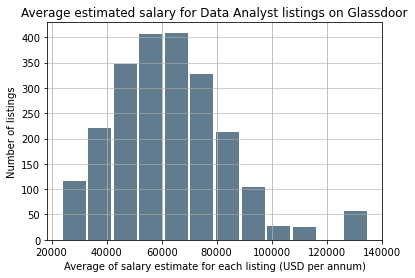

In [15]:
# Generate histogram for median/average salary.
df['Median Estimate'].plot.hist(grid=True, bins=12, rwidth=0.9, color='#607c8e')

plt.title('Average estimated salary for Data Analyst listings on Glassdoor')
plt.xlabel('Average of salary estimate for each listing (USD per annum)')
plt.ylabel('Number of listings')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 0, 'Average salary for job posting on Glassdoor (USD per annum)')

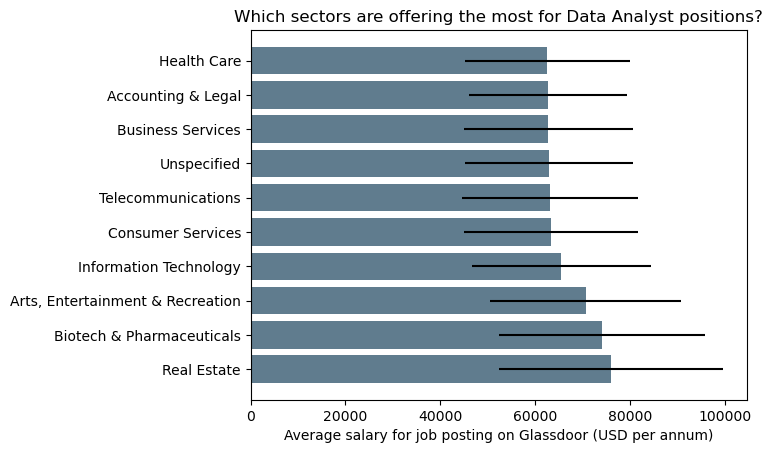

In [16]:
plt.rcdefaults();
fig, ax = plt.subplots();

sector_sort = df.groupby(by=['Sector'], axis=0).mean().sort_values('Median Estimate', ascending=False).head(10)

ax.barh(sector_sort.index, sector_sort['Median Estimate'], xerr=(sector_sort['Upper Estimate']- sector_sort['Lower Estimate'])/2, align='center', color='#607c8e');
ax.set_title('Which sectors are offering the most for Data Analyst positions?')
ax.set_xlabel('Average salary for job posting on Glassdoor (USD per annum)')

Text(0.5, 0, 'Average salary for job posting on Glassdoor (USD per annum)')

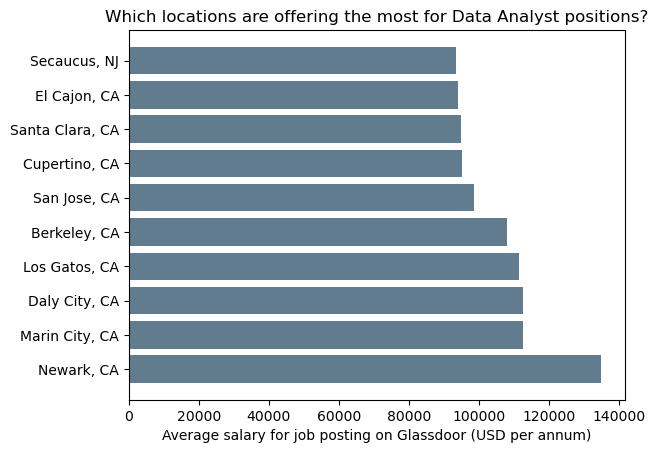

In [17]:
plt.rcdefaults();
fig, ax = plt.subplots();


location_sort = df.groupby(by=['Location'], axis=0).mean().sort_values('Median Estimate', ascending=False).head(10)


ax.barh(location_sort.index, location_sort['Median Estimate'], align='center', color='#607c8e');
ax.set_title('Which locations are offering the most for Data Analyst positions?')
ax.set_xlabel('Average salary for job posting on Glassdoor (USD per annum)')

When grouping the job listings by location we see that average salary estimate for a Data Analyst postion is the highest in California. In fact out of the top 20 cities listed above 17 of those cities are in California. 

Text(0.5, 0, 'Average salary for job posting on Glassdoor (USD per annum)')

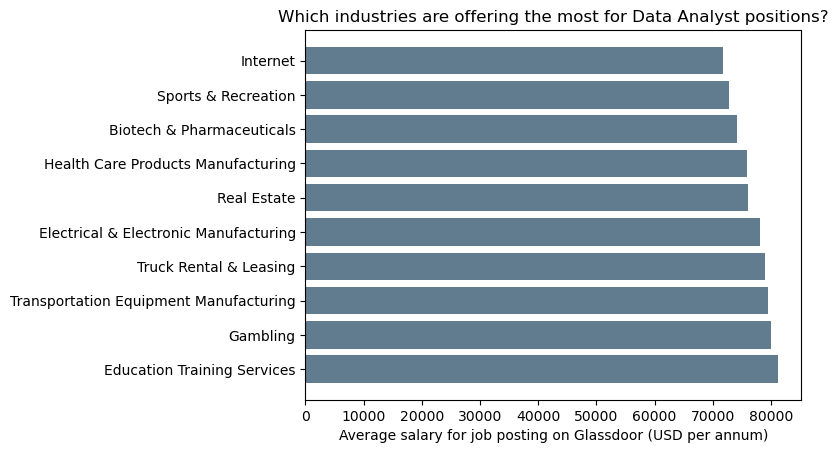

In [18]:
plt.rcdefaults();
fig, ax = plt.subplots();

industry_sort = df.groupby(by=['Industry'], axis=0).mean().sort_values('Median Estimate', ascending=False).head(10)

ax.barh(industry_sort.index, industry_sort['Median Estimate'], align='center',color='#607c8e');
ax.set_title('Which industries are offering the most for Data Analyst positions?')
ax.set_xlabel('Average salary for job posting on Glassdoor (USD per annum)')

In [19]:
df.head()

,Job Title,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Company Age,State,Lower Estimate,Upper Estimate,Median Estimate
0,"Data Analyst, Center on Immigration and Justic...",Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),59,NY,37000,66000,47500.0
1,Quality Data Analyst,Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),127,NY,37000,66000,47500.0
2,"Senior Data Analyst, Insights & Analytics Team...",We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,17,NY,37000,66000,47500.0
3,Data Analyst,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),18,NY,37000,66000,47500.0
4,Reporting Data Analyst,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),11,NY,37000,66000,47500.0


In [20]:
pd.unique(df['Revenue'])

array(['$100 to $500 million (USD)', '$2 to $5 billion (USD)',
       'Unknown / Non-Applicable', '$50 to $100 million (USD)',
       '$1 to $2 billion (USD)', '$5 to $10 billion (USD)',
       '$1 to $5 million (USD)', '$25 to $50 million (USD)',
       '$10+ billion (USD)', 'Less than $1 million (USD)',
       '$10 to $25 million (USD)', '$500 million to $1 billion (USD)',
       '$5 to $10 million (USD)'], dtype=object)

In [21]:
pd.get_dummies(df['Size'])

,1 to 50 employees,10000+ employees,1001 to 5000 employees,201 to 500 employees,5001 to 10000 employees,501 to 1000 employees,51 to 200 employees,Unknown
0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
2248,0,0,0,0,0,0,1,0
2249,0,1,0,0,0,0,0,0
2250,0,0,0,0,0,0,0,1
2251,0,0,0,1,0,0,0,0


Now that we have cleaned up our data and done our initial analysis let's see if we can build a linear regression model to predict the median salary estimate based company features.

For our model the features of interest are:
* Rating
* Location
* Size
* Company Age
* Industry
* Sector
* Revenue

In another blog post I would like to pull out key job requirements from the job description as this most likely has the most influence on salary but my level of skill is not quite there yet.



## Selecting our initial features and responses

In [22]:
y = df['Median Estimate']
X = df[['Rating','State','Size','Company Age','Industry','Sector']]


There is a large amount of categorical data in this model and encoding them with dummy variables leaves us with 156 columns. While this is not ideal it still falls within the rule of thumb of 10 samples for every column (we have 2252 samples).

In [23]:
X = pd.get_dummies(data=X, dummy_na=False)

## Splitting data into testing and training samples

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)


 ## Choosing a model

In [25]:
lr_model = LinearRegression(normalize = True)

In [26]:
lr_model.fit(X_train, y_train)

LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
#Predict and score the model
y_test_preds = lr_model.predict(X_test) 

#Rsquared and y_test
rsquared_score = r2_score(y_test, y_test_preds)
length_y_test = len(y_test)

"The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test)

The model doesn't do very well here so I plotted the learning curves below:

(0.0, 40.0)

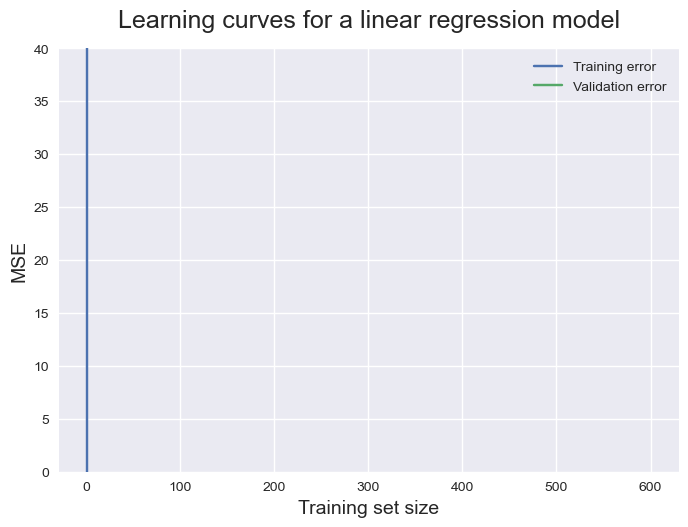

In [27]:
#Creating buckets for our training sizes.

train_sizes = [1, 50, 100, 200, 400, 600]

train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = X_train,
y = y_train, train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1 )


plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,40)

At this point I'm not sure if the feature selection/ dataset as a whole is a poor predictor of estimated salary or I have made mistakes in the process. (I'm 90% sure it is the later). I will submit this as the modelling part doesn't feature in the blog post but I would definitely like to get feedback to figure out what I am doing wrong.